# Mimic Observed Data

If an experiment is already available (in form of noisy state profiles), the user can use the `fit_and_augment` class to fit the model parameters and generate "look-alike-profiles" from the observed profile. The class represents a wrapper of a parameter estimation routine and a subsequent ODE integrator for generating new experiments.

Let us consider a batch run that was performed in the lab, where three species were observed over some time. Example data can be loaded via `insidapy.testdata.generate_test_data()`, where some example rate constants (which we want to estimate later on) are loaded as well:

[+] Saving figure:
	->png: ./figures\observed_state_profiles.png


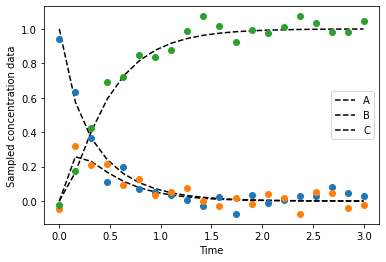

In [1]:
from insidapy.testdata import generate_test_data
y_noise, tspan, rateconstants = generate_test_data(plotting=True, save=True)

Besides these data points, the modeler has an idea about the structure of the ODE system. The system is provided as a callable function `ODEMODEL`. This ODE model file has a similar structure as [shown in the custom ODE case](https://insidapy.readthedocs.io/en/latest/notebooks/main_custom_ode_with_arguments.html), namely `func(t,y,params)`. However, here, the `params` should be in the form of an array! The file could like like the following:

In [2]:
import numpy as np
def odemodel(t, y, params):
    """Custom ODE system. A batch reactor is modeled with two species. The following system
    is implemented: A <-[k1],[k2]-> B -[k3]-> C

    Args:
        y (array): Concentration of species of shape [n,].
        t (scalar): time.
        coefs (dict): Dictionary of coefficients or other information.

    Returns:
        array: dydt - Derivative of the species of shape [n,].
    """
    # Variables  
    A = y[0]
    B = y[1]
    C = y[2]
    # Parameters
    k1 = params[0]
    k2 = params[0]
    k3 = params[0]   
    # Rate expressions
    dAdt = k2*B - k1*A
    dBdt = k1*A - k2*B - k3*B
    dCdt = k3*B
    # Vectorization
    dydt = np.array((dAdt, dBdt, dCdt))
    # Return
    return dydt.reshape(-1,)

For the parameter estimation, some `PARAMBOUNDS` (array of `n`$\times$`2`, with `n` being the number of parameters to be estimated) are required. We also prepare a list for the units of the species.

In [3]:
import numpy as np
PARAMBOUNDS = np.zeros((3,2))
PARAMBOUNDS[:,1] = 5
RS_STEPS = 5
SPECIES_UNITS = ['g/L', 'g/L', 'g/L']

Next, we can instantiate the `fit_and_augment` object, fit the data, and predict the state profiles with the identified parameter values:

In [4]:
from insidapy.augment.mimic import fit_and_augment
obj = fit_and_augment(y=y_noise,
                      t=tspan,
                      nparams=len(rateconstants),
                      parameter_bounds=PARAMBOUNDS,
                      model=odemodel,
                      species_units=SPECIES_UNITS) # If "None" is given, "n.a." is used for each species

Then, the parameters are estimated using the `fit` method, and predicted using the `predict` method. Both can be done together in one step using the `fit_predict` method, too. The `fit` method uses the scipy implementations, so the standard scipy optimization routines can be used by indicating the appropriate `method` argument.

[+] Performt parameter estimation. Stored values under "self.xopt".
[+] Performed prediction with identified parameters. Stored under "self.y_fit".
[+] Saving figure:
	->png: ./figures\parameter_estimation_example.png


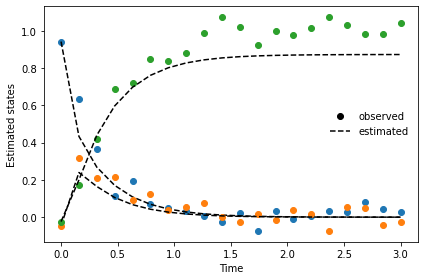

In [5]:
obj.fit(method='Nelder-Mead', objective='RMSE', num_random_search_steps=RS_STEPS)
obj.predict(show=True,
            save=True, 
            figname='parameter_estimation_example',
            save_figure_directory='./figures', 
            save_figure_exensions=['png'])

After having estimated the parameters and checked the model predictions, we can create upper and lower bounds for the initial conditions to generate new experiments with the found parameters:

After this preparation work, we can define the initial conditions for new batch runs that should be generated (design of experiments). This is done automatically, where we only need the bounds of the initial conditions. Here, we generate those by just taking half of the observed concentration value as a lower bound, and 1.5 times the values for the upper bound:

In [6]:
lower_bounds = y_noise[0,:]*0.5
upper_bounds = y_noise[0,:]*1.5     

We then mimic the observed data by using the `mimic_experiments` method (it basically uses our estimated parameters from before to generate new batches):

In [7]:
obj.mimic_experiments(  LB=lower_bounds, 
                        UB=upper_bounds, 
                        nbatches=3,
                        noise_mode = 'percentage',
                        noise_percentage = 2.5)

[+] Mimiced 3 experiments based on the identified parameters.


As in the `batch` class, the generated data can be plotted:

[+] Saving figure:
	->png: .\figures\mimiced_experiments_custom_ode.png


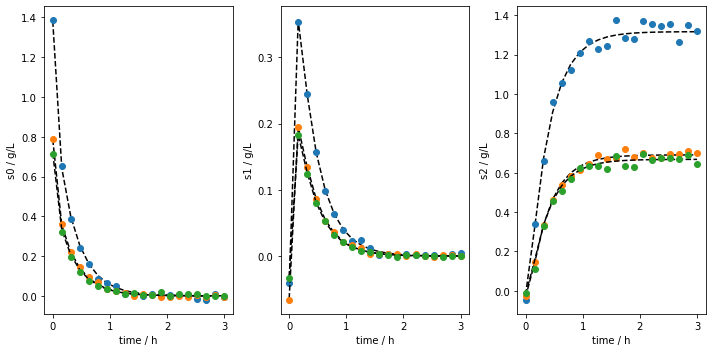

In [8]:
obj.plot_experiments(   show=True,
                        save=True, 
                        figname='mimiced_experiments_custom_ode', 
                        save_figure_directory=r'.\figures', 
                        save_figure_exensions=['png'])

Most modeling approaches require a training dataset and a separate testing dataset. To generate separate datasets, the user can apply a splitting in an sklearn-manner. There is no default value set. In case the user calls the function, a `test_splitratio` in the range [0,1) needs to be chosen. The value represents the fraction of the total number of batches generated used for the test set. The data is then splitted and stored in the data object as `data.training` and `data.testing`. 

In [9]:
obj.train_test_split(test_splitratio=0.2)

We can now also plot the experiments while showing the training and testing runs individually. The method lets us save the figure using a path (`save_figure_directory`), a name (`figname`) and an some extensions (`save_figure_exensions`) as a list. By using `show=False`, the plot will not be displayed in a running code.

[+] Saving figure:
	->png: .\figures\mimiced_experiments_custom_ode_train_test.png


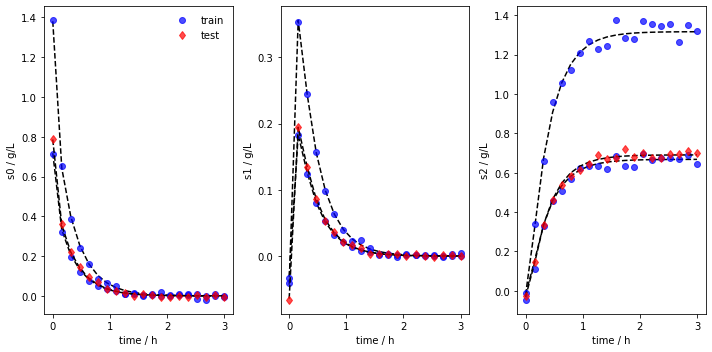

In [10]:
obj.plot_train_test_experiments(save=True, 
                                show=False,
                                figname=f'mimiced_experiments_custom_ode_train_test',
                                save_figure_directory=r'.\figures', 
                                save_figure_exensions=['png'])

After the simulation, one can export the data as XLSX files. By choosing `which_dataset` to be `training` (only executable if `train_test_split` was applied), `testing` (only executable if `train_test_split` was applied), or `all` (always executable), the corresponding data is exported to the indicated location:

In [11]:
obj.export_dict_data_to_excel(destination=r'.\data', which_dataset='all')      # Exports all the data
obj.export_dict_data_to_excel(destination=r'.\data', which_dataset='training') # Exports the training data
obj.export_dict_data_to_excel(destination=r'.\data', which_dataset='testing')  # Exports the training data

[+] Exported batch data to excel.
	-> Dataset: ALL (options: training, testing, all)
	-> Noise free data to: .\data\augment_fit_case_study_all.xlsx
	-> Noisy data to: .\data\augment_fit_case_study_all_noisy.xlsx
[+] Exported batch data to excel.
	-> Dataset: TRAINING (options: training, testing, all)
	-> Noise free data to: .\data\augment_fit_case_study_training.xlsx
	-> Noisy data to: .\data\augment_fit_case_study_training_noisy.xlsx
[+] Exported batch data to excel.
	-> Dataset: TESTING (options: training, testing, all)
	-> Noise free data to: .\data\augment_fit_case_study_testing.xlsx
	-> Noisy data to: .\data\augment_fit_case_study_testing_noisy.xlsx
